In [4]:
#!pip install minisom

In [5]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from minisom import MiniSom

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

%matplotlib inline

In [6]:
def som_pie_grid(som, data, labels):
  """Helper to create piechart grid viz
  
  Example: https://raw.githubusercontent.com/JustGlowing/minisom/master/examples/resulting_images/som_iris_pies.png

  :param som: fitted MiniSom instance
  :param data: the data the MiniSom was fit to
  :param labels: an array of labels to use for coloring visual
  """
  labels_map = som.labels_map(data, labels)
  label_names = np.unique(labels)

  plt.figure(figsize=(70, 70))
  the_grid = GridSpec(70, 70)
  for position in labels_map.keys():
      label_fracs = [labels_map[position][lab] for lab in label_names]
      plt.subplot(the_grid[position[1] - 12, position[0]], aspect=1)
      patches, texts = plt.pie(label_fracs)

  plt.show()

  # Cheating way to align legend, create a separate figure just 
  # for legend.  Will have superfluous whitespace below
  plt.legend(patches, label_names, loc='upper left', ncol=5)
  plt.axis('off')
  plt.show()

* Read in the data from `data_url`
* Drop all NAs
* Filter based on the `'Pos'` column to where only have the positions `['C', 'PG', 'SG']` remain
* Drop all non-numeric columns
* Scale the data

In [7]:
data_url = "https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Clustering/nba_player_seasons.csv"

In [8]:
df = pd.read_csv(data_url)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2141 entries, 0 to 2140
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Seas    2141 non-null   int64  
 1   Player  2141 non-null   object 
 2   Pos     2141 non-null   object 
 3   Age     2141 non-null   int64  
 4   Tm      2141 non-null   object 
 5   G       2141 non-null   int64  
 6   GS      2141 non-null   int64  
 7   MP      2141 non-null   float64
 8   FG      2141 non-null   float64
 9   FGA     2141 non-null   float64
 10  FG%     2131 non-null   float64
 11  3P      2141 non-null   float64
 12  3PA     2141 non-null   float64
 13  3P%     1967 non-null   float64
 14  2P      2141 non-null   float64
 15  2PA     2141 non-null   float64
 16  2P%     2110 non-null   float64
 17  eFG%    2131 non-null   float64
 18  FT      2141 non-null   float64
 19  FTA     2141 non-null   float64
 20  FT%     2037 non-null   float64
 21  ORB     2141 non-null   float64
 22  

In [10]:
null = df.isnull().sum()/df.isnull().count()*100
null.sort_values(ascending=True)

Seas      0.000000
TOV       0.000000
BLK       0.000000
STL       0.000000
AST       0.000000
TRB       0.000000
DRB       0.000000
ORB       0.000000
FTA       0.000000
FT        0.000000
2PA       0.000000
PF        0.000000
2P        0.000000
MP        0.000000
Player    0.000000
Pos       0.000000
Age       0.000000
Tm        0.000000
G         0.000000
GS        0.000000
3PA       0.000000
PTS       0.000000
FG        0.000000
FGA       0.000000
3P        0.000000
eFG%      0.467071
FG%       0.467071
2P%       1.447922
FT%       4.857543
3P%       8.127043
dtype: float64

In [11]:
df.dropna(inplace=True)

In [12]:
df.Pos.value_counts()

SG       458
PG       410
PF       386
SF       341
C        286
SF-SG      4
PF-C       3
PF-SF      2
SG-SF      2
PG-SG      1
SG-PF      1
C-PF       1
Name: Pos, dtype: int64

In [13]:
df_fil = df.loc[df['Pos'].isin(['C', 'PG', 'SG'])].reset_index(drop=True)

In [14]:
df_fil.drop(columns=['Player','Tm'], inplace=True)

In [15]:
df_fil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154 entries, 0 to 1153
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Seas    1154 non-null   int64  
 1   Pos     1154 non-null   object 
 2   Age     1154 non-null   int64  
 3   G       1154 non-null   int64  
 4   GS      1154 non-null   int64  
 5   MP      1154 non-null   float64
 6   FG      1154 non-null   float64
 7   FGA     1154 non-null   float64
 8   FG%     1154 non-null   float64
 9   3P      1154 non-null   float64
 10  3PA     1154 non-null   float64
 11  3P%     1154 non-null   float64
 12  2P      1154 non-null   float64
 13  2PA     1154 non-null   float64
 14  2P%     1154 non-null   float64
 15  eFG%    1154 non-null   float64
 16  FT      1154 non-null   float64
 17  FTA     1154 non-null   float64
 18  FT%     1154 non-null   float64
 19  ORB     1154 non-null   float64
 20  DRB     1154 non-null   float64
 21  TRB     1154 non-null   float64
 22  

In [16]:
X = df_fil.drop(columns=['Pos'])
y = df_fil['Pos']

scale = StandardScaler()
scaled = scale.fit_transform(X)

In [21]:
df_fil

,Seas,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2019,SG,25,31,2,19.0,1.8,5.1,0.357,1.3,4.1,0.323,0.5,1.0,0.500,0.487,0.4,0.4,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
1,2019,PG,22,34,1,12.6,1.1,3.2,0.345,0.7,2.2,0.338,0.4,1.1,0.361,0.459,0.2,0.3,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
2,2019,C,25,80,80,33.4,6.0,10.1,0.595,0.0,0.0,0.000,6.0,10.1,0.596,0.595,1.8,3.7,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
3,2019,C,21,82,28,23.3,3.4,5.9,0.576,0.0,0.2,0.200,3.4,5.7,0.588,0.579,2.0,2.8,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9
4,2019,SG,25,7,0,3.1,0.4,1.4,0.300,0.0,0.6,0.000,0.4,0.9,0.500,0.300,0.1,0.3,0.500,0.1,0.4,0.6,0.9,0.3,0.0,0.3,0.6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,2016,PG,22,8,3,18.0,2.8,8.1,0.338,0.4,2.1,0.176,2.4,6.0,0.396,0.362,2.5,4.6,0.541,0.3,2.4,2.6,2.5,0.4,0.0,3.6,1.4,8.4
1150,2016,SG,20,29,0,6.9,0.4,1.2,0.306,0.2,0.9,0.231,0.2,0.3,0.500,0.389,0.0,0.1,0.250,0.1,0.8,0.9,0.3,0.2,0.0,0.2,0.6,1.0
1151,2016,PG,23,41,0,9.4,1.5,4.1,0.367,0.2,1.1,0.217,1.3,3.0,0.423,0.396,0.5,0.6,0.800,0.1,1.1,1.2,1.6,0.4,0.0,0.8,0.7,3.8
1152,2016,SG,30,54,2,19.1,2.3,6.9,0.339,1.4,4.4,0.325,0.9,2.5,0.363,0.442,1.2,1.4,0.829,0.3,1.5,1.8,0.6,0.4,0.1,0.6,0.9,7.3


In [19]:
X

,Seas,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2019,25,31,2,19.0,1.8,5.1,0.357,1.3,4.1,0.323,0.5,1.0,0.500,0.487,0.4,0.4,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
1,2019,22,34,1,12.6,1.1,3.2,0.345,0.7,2.2,0.338,0.4,1.1,0.361,0.459,0.2,0.3,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
2,2019,25,80,80,33.4,6.0,10.1,0.595,0.0,0.0,0.000,6.0,10.1,0.596,0.595,1.8,3.7,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
3,2019,21,82,28,23.3,3.4,5.9,0.576,0.0,0.2,0.200,3.4,5.7,0.588,0.579,2.0,2.8,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9
4,2019,25,7,0,3.1,0.4,1.4,0.300,0.0,0.6,0.000,0.4,0.9,0.500,0.300,0.1,0.3,0.500,0.1,0.4,0.6,0.9,0.3,0.0,0.3,0.6,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,2016,22,8,3,18.0,2.8,8.1,0.338,0.4,2.1,0.176,2.4,6.0,0.396,0.362,2.5,4.6,0.541,0.3,2.4,2.6,2.5,0.4,0.0,3.6,1.4,8.4
1150,2016,20,29,0,6.9,0.4,1.2,0.306,0.2,0.9,0.231,0.2,0.3,0.500,0.389,0.0,0.1,0.250,0.1,0.8,0.9,0.3,0.2,0.0,0.2,0.6,1.0
1151,2016,23,41,0,9.4,1.5,4.1,0.367,0.2,1.1,0.217,1.3,3.0,0.423,0.396,0.5,0.6,0.800,0.1,1.1,1.2,1.6,0.4,0.0,0.8,0.7,3.8
1152,2016,30,54,2,19.1,2.3,6.9,0.339,1.4,4.4,0.325,0.9,2.5,0.363,0.442,1.2,1.4,0.829,0.3,1.5,1.8,0.6,0.4,0.1,0.6,0.9,7.3


In [20]:
y

0       SG
1       PG
2        C
3        C
4       SG
        ..
1149    PG
1150    SG
1151    PG
1152    SG
1153     C
Name: Pos, Length: 1154, dtype: object

* Fit a `MiniSom` instance to the scaled data
  * Choose your own grid size
  * Set a `random_seed` to have reproducible results
  * Initialize the `MiniSom` weight vectors using `.pca_weights_init()` or `.random_weights_init()`
  * Train the model using `.train_random()` or `.train_batch()`

In [36]:
n_cols = X.shape[1]
grid_cols = 10
grid_rows = 10

som = MiniSom(grid_cols, grid_rows, n_cols, random_seed=22)

som.random_weights_init(scaled)
som.train_random(scaled, num_iteration=100, verbose=True)

 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 3.0659846166381968


* Use the helper function defined at the top of the notebook to plot the SOM's fit
  * Use the players' positions (the `'Pos'` column) as the labels in the viz
  * Experiment with the SOM's grid size, initialization method, and training method.  Decide a 'good' fit using this visual as guidance.

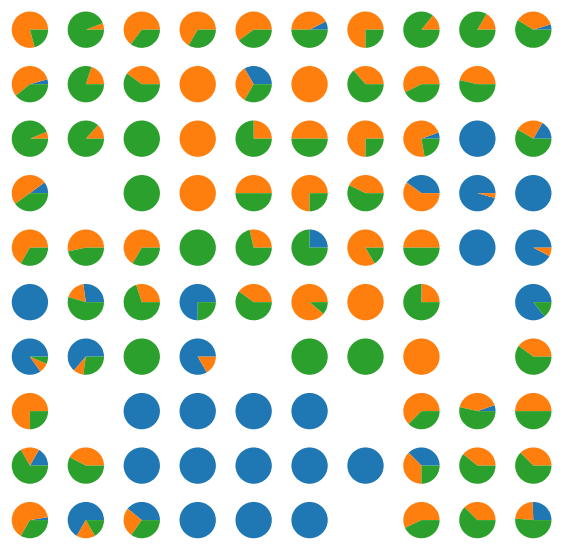

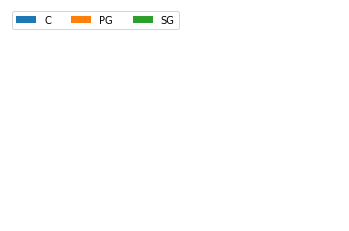

In [37]:
som_pie_grid(som, scaled, y)

* Perform dimension reduction (to 2d) with another method (perhaps `PCA` or `TSNE`).
* Create a scatter plot of the results of this dimension reduction and color the scatter plot by the players' positions (the `'Pos'` column).
  * How do these results compare to that of the SOM? What are the pros and cons of the different approaches you took in this notebook?

In [24]:
pca = PCA(n_components=2)
pca_ = pd.DataFrame(pca.fit_transform(scaled), index=df_fil.index)

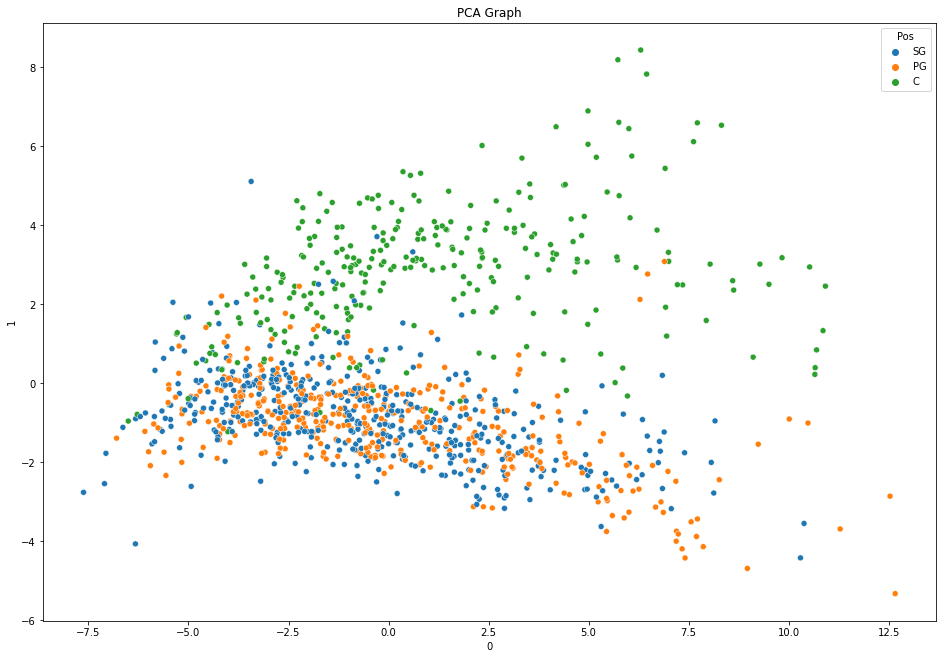

In [26]:
plt.figure(figsize=(16, 11))
sns.scatterplot(data=pca_, x=pca_[0], y=pca_[1], hue=y)
plt.title("PCA Graph")
plt.show()

In [28]:
tsne = TSNE(n_components=2)
tsne_ = pd.DataFrame(tsne.fit_transform(scaled), index=df_fil.index)

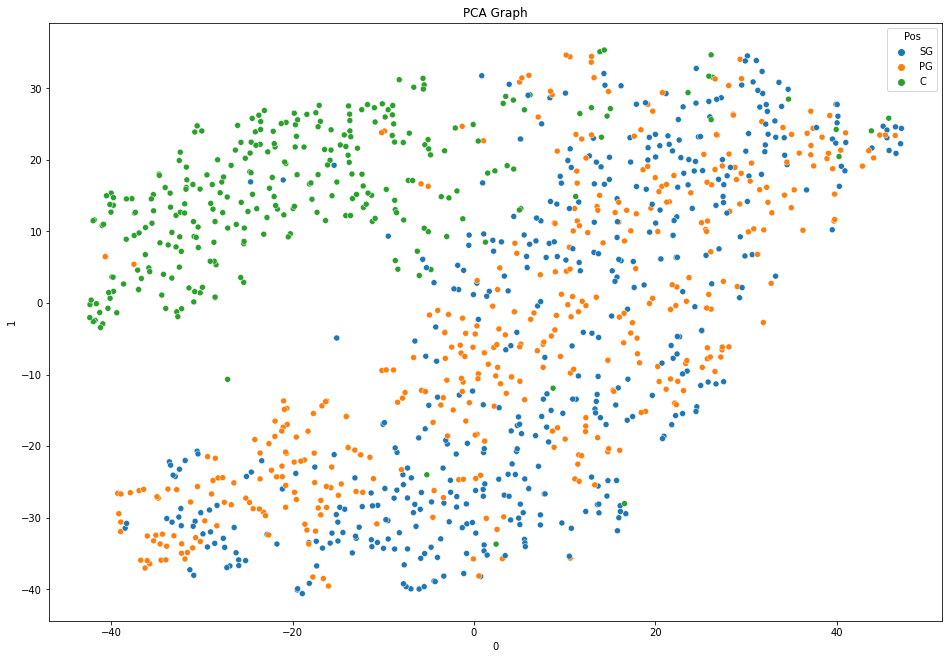

In [29]:
plt.figure(figsize=(16, 11))
sns.scatterplot(data=tsne_, x=tsne_[0], y=tsne_[1], hue=y)
plt.title("PCA Graph")
plt.show()

All the methods do a pretty solid job of identifying the 'C' position. But the stats and characteristics of the two Guard positions ('SG' and 'PG') are harder to differentiate between. TSNE does a good job of spreading things out but still has a hard time telling the two guard positions apart. Similar results are found within the pie grid. Quite a few pies are solidly one or the other guard positions but most of them are a combition of both. 